1. Data loading
2. EDA numerical/categorical <= 30'
3. Data preparation for ML
4. Baseline Model & Main Model
5. Train / eval / export
6. Function for prediction <= 45'
7. NLP feature...

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('./data/train.csv')
df.head()

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,1748,austin,MULTIPLE OFFERS submit best & final to Agent b...,Single Family,30.380089,-97.800621,0,False,1988,0,102366.0,7.000000,17,4.0,4,650000+
1,13380,austin,"4644 Hoffman Dr, Austin, TX 78749 is a single ...",Single Family,30.199486,-97.859947,0,False,1997,0,6534.0,6.666667,16,3.0,4,350000-450000
2,4115,austin,"6804 Canal St, Austin, TX 78741 is a single fa...",Single Family,30.227398,-97.696083,0,False,1952,0,5619.0,3.333333,11,1.0,2,0-250000
3,6926,austin,Beautiful large lot with established trees. Lo...,Single Family,30.205469,-97.792351,4,False,1976,0,6416.0,4.000000,14,2.0,4,0-250000
4,14480,austin,Stunning NW Hills designer remodel by Cedar an...,Single Family,30.345106,-97.767426,2,False,1984,0,10759.0,7.000000,16,3.0,5,650000+


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   uid                         10000 non-null  int64  
 1   city                        10000 non-null  object 
 2   description                 9999 non-null   object 
 3   homeType                    10000 non-null  object 
 4   latitude                    10000 non-null  float64
 5   longitude                   10000 non-null  float64
 6   garageSpaces                10000 non-null  int64  
 7   hasSpa                      10000 non-null  bool   
 8   yearBuilt                   10000 non-null  int64  
 9   numOfPatioAndPorchFeatures  10000 non-null  int64  
 10  lotSizeSqFt                 10000 non-null  float64
 11  avgSchoolRating             10000 non-null  float64
 12  MedianStudentsPerTeacher    10000 non-null  int64  
 13  numOfBathrooms              1000

In [11]:
df.drop('uid', axis=1, inplace=True)

In [12]:
df['priceRange'].value_counts()/len(df)

priceRange
250000-350000    0.2356
350000-450000    0.2301
450000-650000    0.2275
650000+          0.1819
0-250000         0.1249
Name: count, dtype: float64

In [14]:
df['ageBuilding'] = 2025 - df['yearBuilt']
df.drop('yearBuilt', axis=1, inplace=True)

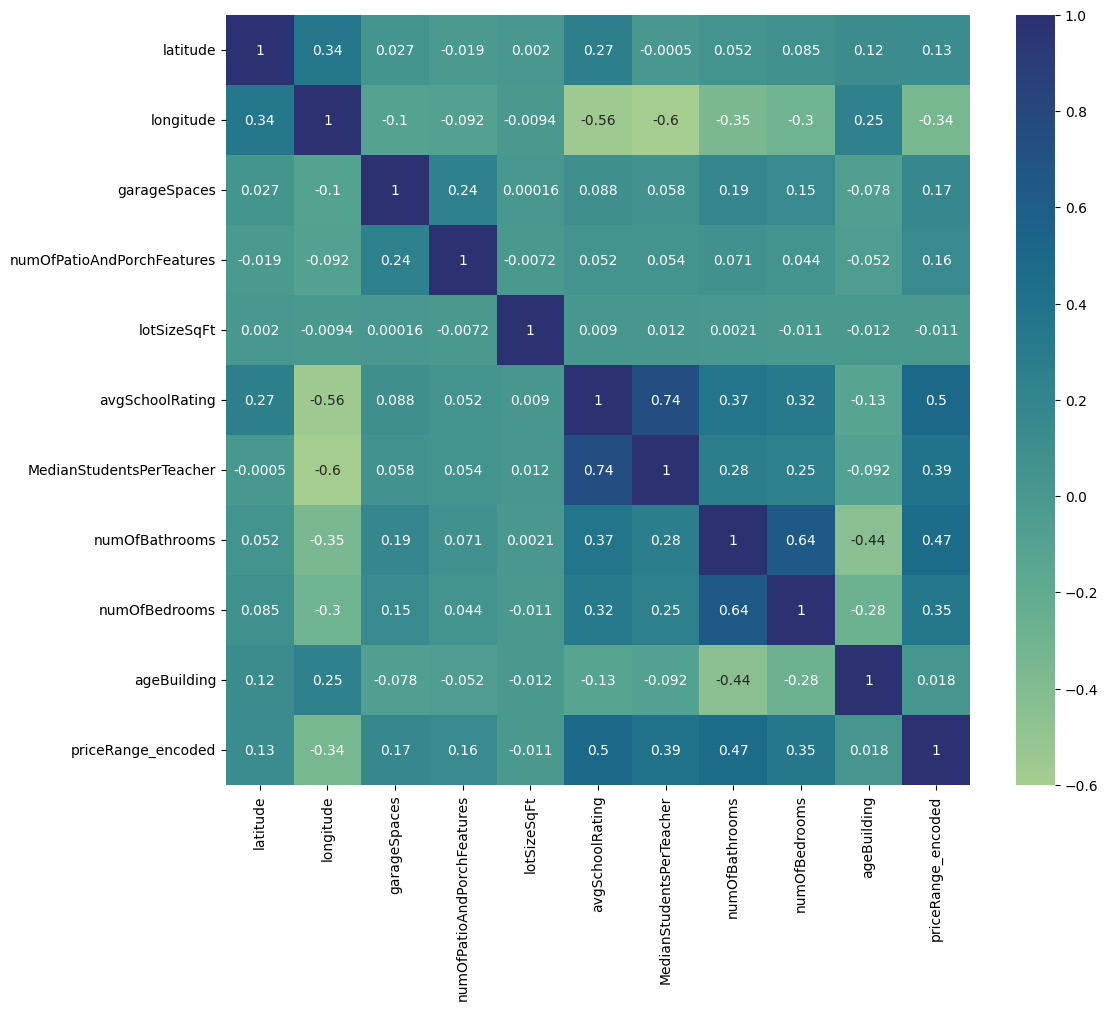

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['priceRange_encoded'] = le.fit_transform(df['priceRange'])

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='crest')
plt.show()

In [22]:
# dropping highly correlated features
df.drop(['MedianStudentsPerTeacher', 'numOfBedrooms'], axis=1, inplace=True)

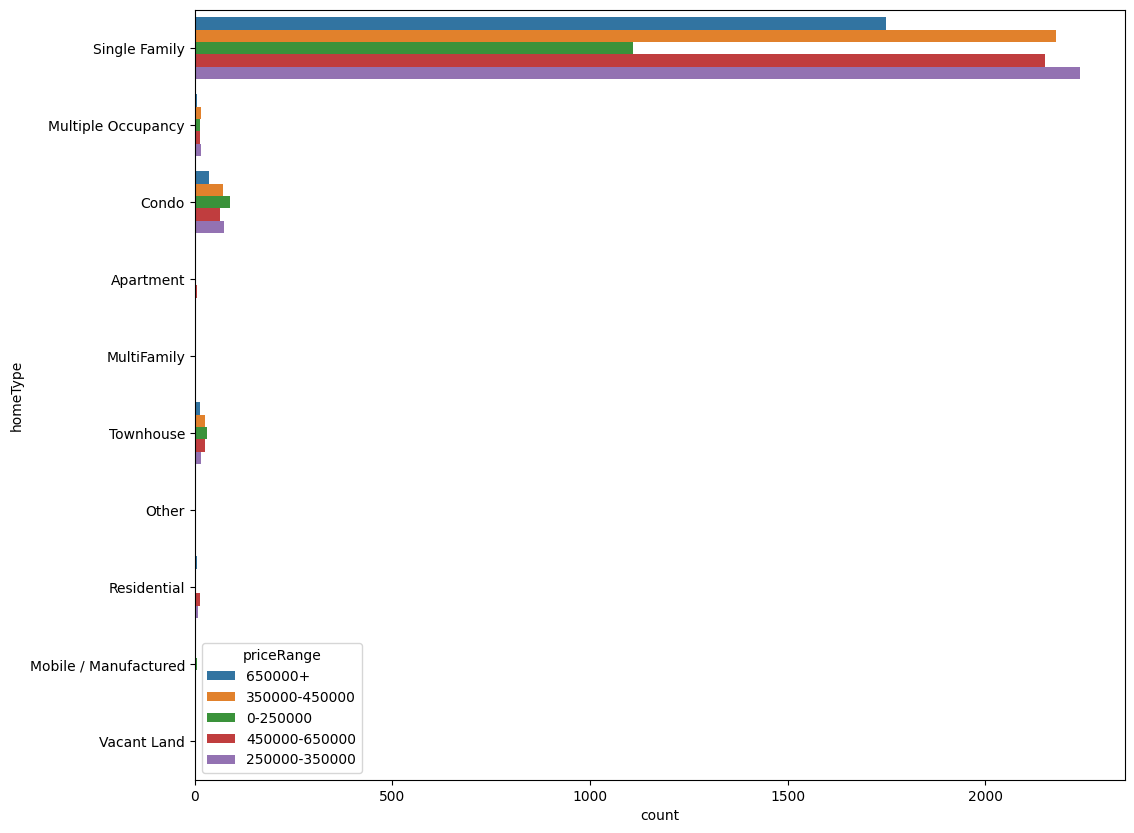

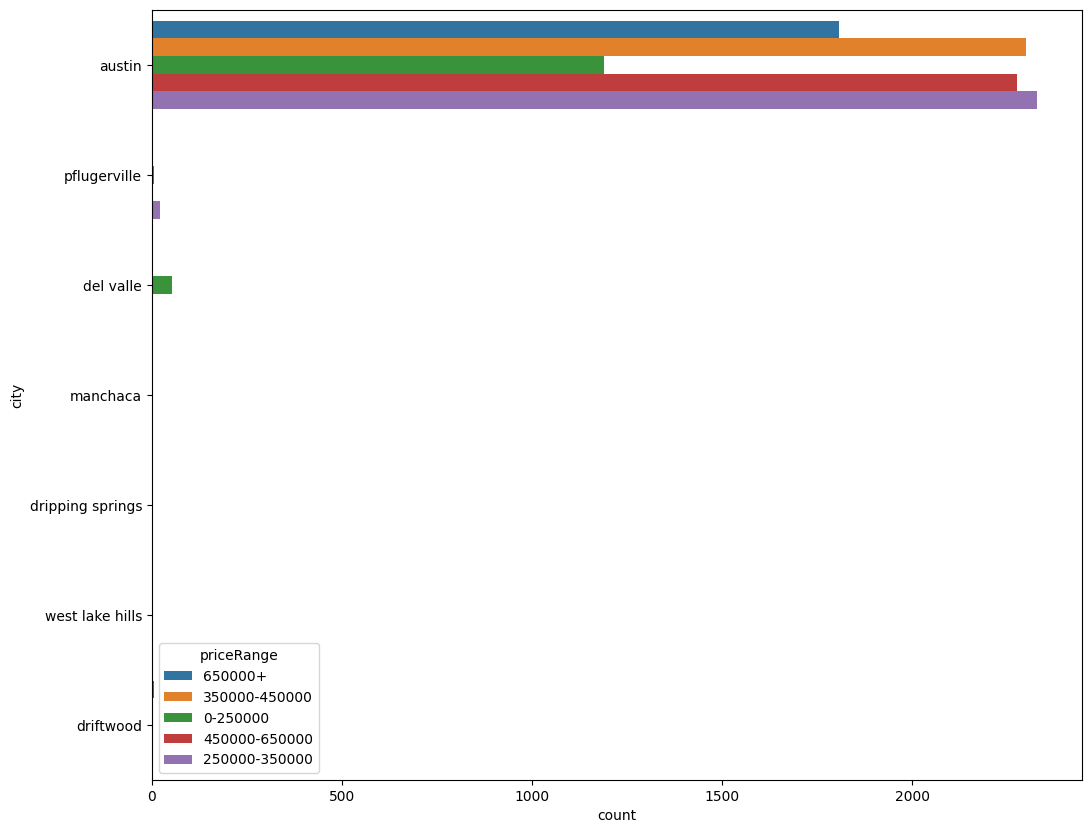

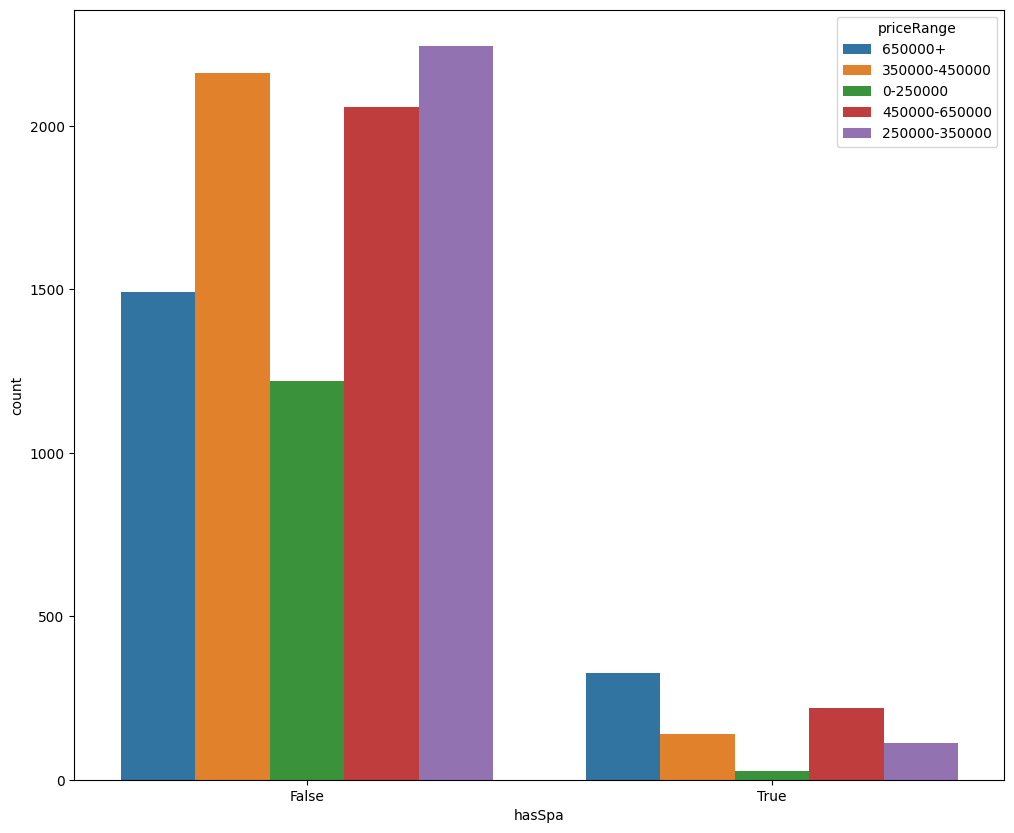

In [27]:
plt.figure(figsize=(12,10))
sns.countplot(data=df, y='homeType', hue='priceRange')
plt.show()
plt.figure(figsize=(12,10))
sns.countplot(data=df, y='city', hue='priceRange')
plt.show()
plt.figure(figsize=(12,10))
sns.countplot(data=df, x='hasSpa', hue='priceRange')
plt.show()

In [ ]:
# Data preparation before training
X = df.drop(['priceRange','priceRange_encoded','description'], axis=1)
y = df['priceRange_encoded']

In [ ]:
# Data preparation and transformations

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import lightgbm as lgbm
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object', 'bool']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(),numeric_columns),
        ('cat', OneHotEncoder(),categorical_columns)
    ]
)

In [32]:
# Logistic Regression model training
lr_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ]
)

lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)

In [35]:
#LightGBM model training
lgbm_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', lgbm.LGBMClassifier(importance_type='gain'))
    ]
)

lgbm_pipeline.fit(X_train, y_train)

y_pred_lgbm = lgbm_pipeline.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 17
[LightGBM] [Info] Start training from score -2.080585
[LightGBM] [Info] Start training from score -1.445741
[LightGBM] [Info] Start training from score -1.469055
[LightGBM] [Info] Start training from score -1.480291
[LightGBM] [Info] Start training from score -1.704534


c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [36]:
from sklearn.metrics import f1_score, accuracy_score

print('Logistic Regression Results:')
print('F1-score: ',f1_score(y_test, y_pred_lr, average='weighted'))
print('Accuracy: ',accuracy_score(y_test, y_pred_lr))

print('LightGBM Results:')
print('F1-score: ',f1_score(y_test, y_pred_lgbm, average='weighted'))
print('Accuracy: ',accuracy_score(y_test, y_pred_lgbm))

Logistic Regression Results:
F1-score:  0.46855304103342127
Accuracy:  0.47333333333333333
LightGBM Results:
F1-score:  0.6179867808141689
Accuracy:  0.6186666666666667


In [54]:
# Feature Importance
feature_names = numeric_columns + \
                list(lgbm_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_columns))
feature_importances = lgbm_pipeline.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance':feature_importances}).sort_values('Importance', ascending=False)

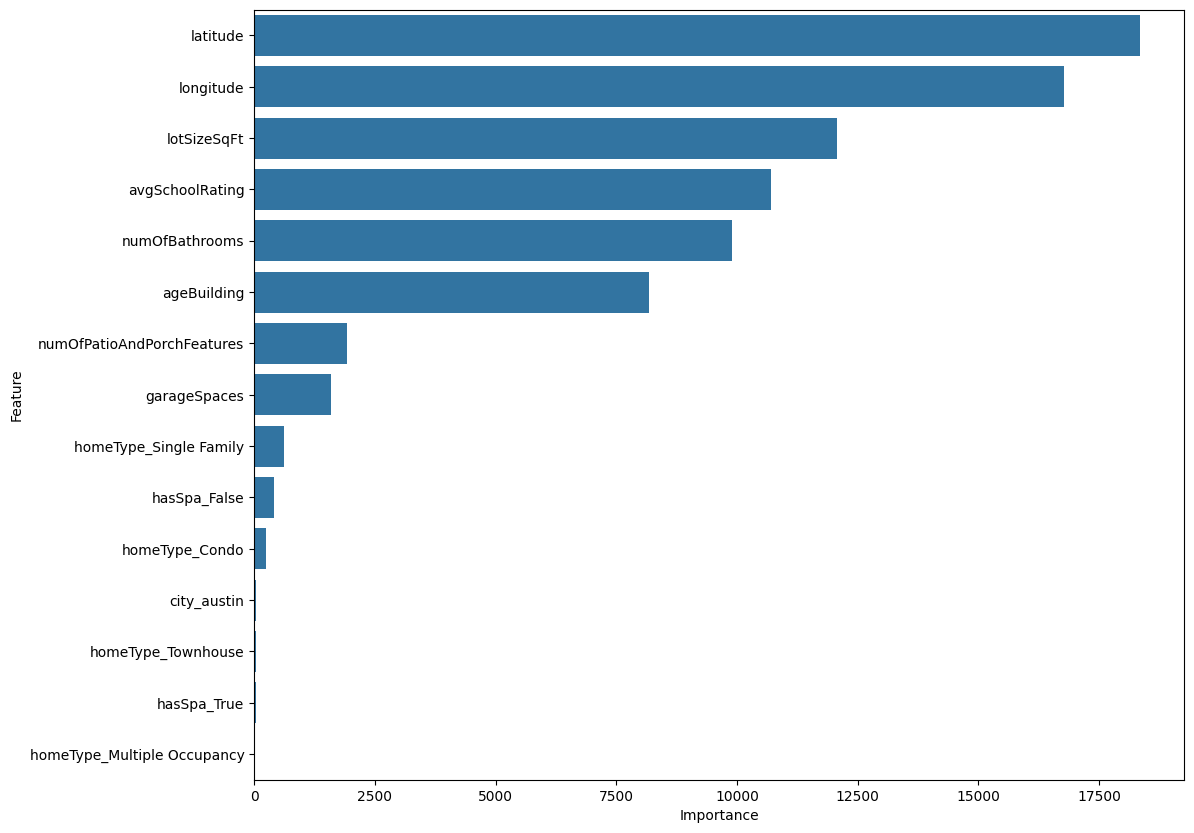

In [58]:
plt.figure(figsize=(12,10))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
plt.show()

In [59]:
# Model export
import joblib

output_dir = './outputs/'
joblib.dump(lgbm_pipeline, output_dir + 'lgbm_price_range_pipline.joblib')
joblib.dump(le, output_dir + 'label_encoder.joblib')

['./outputs/label_encoder.joblib']

In [65]:
# Prediction Function
def predict_price_range(data: pd.DataFrame):
    import joblib
    try:
        model_pipeline = joblib.load(r'C:\Users\gabyl\OneDrive\Desktop\ML_test\outputs\lgbm_price_range_pipline.joblib')
        label_encoder = joblib.load(r'C:\Users\gabyl\OneDrive\Desktop\ML_test\outputs\label_encoder.joblib')
    except:
        "[ERROR] Pipeline or Encoder not found."

    prediction_encoded = model_pipeline.predict(data)
    predicted_price_range = label_encoder.inverse_transform(prediction_encoded)

    probabilities = model_pipeline.predict_proba(data)

    return predicted_price_range, probabilities

In [70]:
# Lets test the prediction function:
print(predict_price_range(X_train.iloc[5:6]))
df['priceRange'].iloc[5:6]

(array(['650000+'], dtype=object), array([[0.00154783, 0.00605208, 0.01548899, 0.10710578, 0.86980532]]))


c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


5    450000-650000
Name: priceRange, dtype: object

In [ ]:
# NLP feature:
# 1. lowercase
# 2. filter out the symbols
# 3. tokenize / split into words/tokens
# 4. Lemmatize -> transform words to it's root meaning
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk 

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def our_tokenizer(text: str):

    text = text.lower()
    text = re.sub('^a-z', '', text) #TODO: fix regex to avoid symbols
    text = text.split()
    
    processed_token = []
    for word in text:
        if word not in stop_words:
            if len(word) > 3:
                processed_token.append(lemmatizer.lemmatize(word))

    return processed_token

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabyl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gabyl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    tokenizer = our_tokenizer
)

preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(),numeric_columns),
        ('cat', OneHotEncoder(),categorical_columns),
        ('nlp', vectorizer, 'description')
    ]
)

final_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', lgbm.LGBMClassifier(importance_type='gain'))
    ]
)

#TODO: 
# Use the original dataset to include 'description column
# Do the train_test_split again
# Fit the train data to the new pipeline
# See the models score
# Do the feature importance part again
# Then do some GridsearchCV on the LightGBM Classifier hgyperparameter, and maybe on the TfidfVectorizer
# See the models improvement
# Export full model
